Initial world


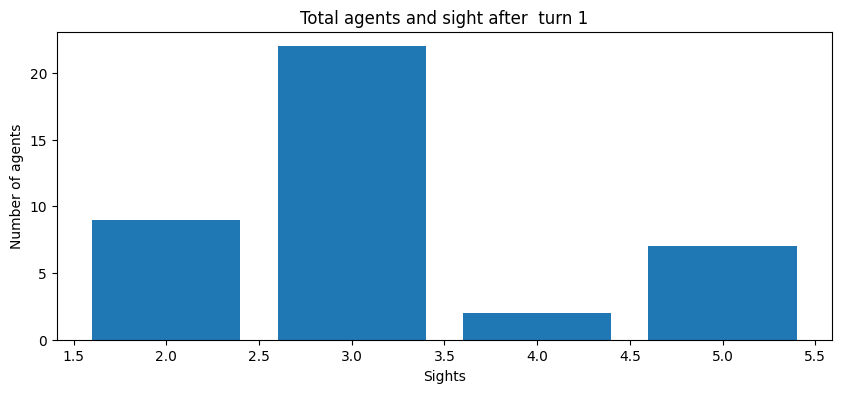

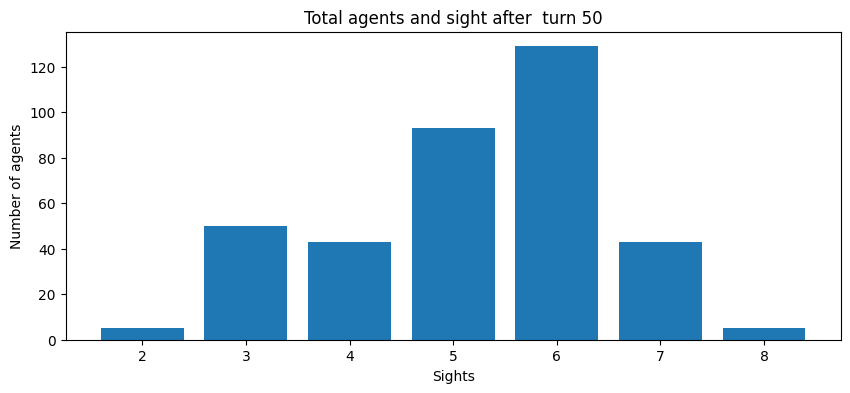

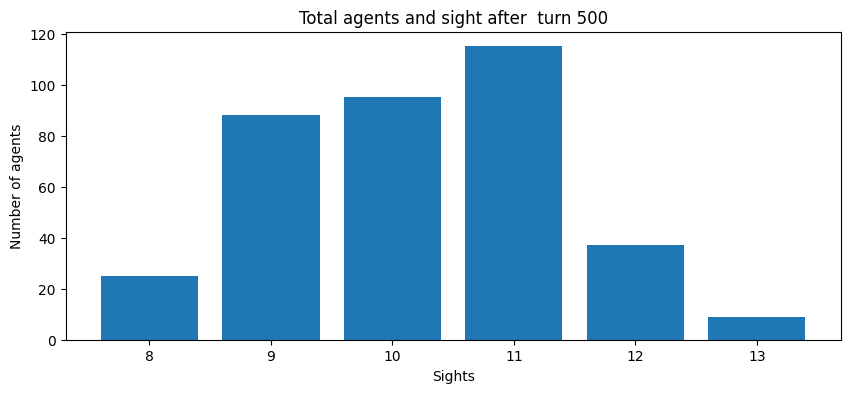

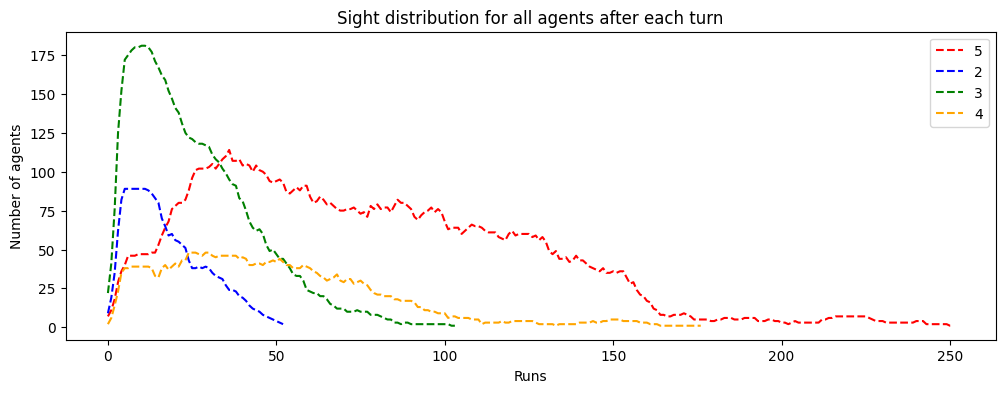

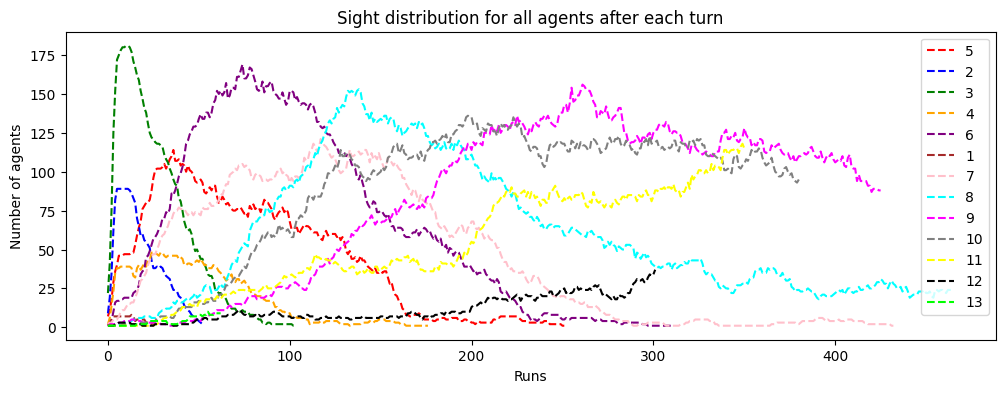

In [1]:
from enum import Enum
import math
import random

##directional cardinal vectors
class Direction(Enum):
    NORTH = -1, 0 
    SOUTH = 1, 0
    EAST = 0, 1
    WEST = 0,-1

#defines the direction for reproduction
class BirthPlace(Enum):
    SOUTHEAST  = 1,1 
    NORTHWEST  = -1,-1 
    SOUTHWEST  = 1,-1 
    NORTHEAST = -1,1

#defining agent class
class Agent:
    def __init__(self,name):
        self.energy = 10
        self.sight = random.randint(2,5)
        self.name = name
        self.pos = None
        self.vision = {}
        self.listVision = []
        self.detail = ""
    
    #define  movement for agent
    #makes agent to to loccation with highest sugar
    def move(self):
        loc = self.whereTo()
        if loc and loc != self.pos:
            world.grid[self.pos[0]][self.pos[1]] = None
            world.grid[loc[0]][loc[1]] = self
            self.updateEnergy(loc)
            self.vision = {}
            self.pos = loc
  
    #update agent energy after 
    #reducate sugar level in world
    def updateEnergy(self, loc):
        if loc in world.sugar:
            self.energy += world.sugar[loc]
            world.reduceSugar(loc)
        
        self.detail += f"Agent's Energy: {self.energy}\n"
        self.detail += f'sugar Level: {world.sugar[loc]}\n'

    #determines the next location agents wants to collect sugar
    def whereTo(self):
        self.computeVision()
        vision_sugar = {}
        
        for key in self.vision:
            if key in world.sugar and (self.isFree(key) or key == self.pos):
                vision_sugar[key] = world.sugar[key]  
        try:
            max_vision = max(vision_sugar, key=vision_sugar.get)
            max_visions = [key for key, value in vision_sugar.items() if value == vision_sugar[max_vision]]
            rand = random.randint(0, len(max_visions)-1)
            max_vision = max_visions[rand]

            self.detail += f'vision_sugar: {vision_sugar} - length: {len(vision_sugar)}\n'
            self.detail += f'next move: {max_vision}\n'
            return max_vision
        except ValueError:
            return None
    
    #Checks of a specified state is free 
    #@para: loc - state to be checked
    #return True is free, False otherwise
    def isFree(self, loc):
        if world.grid[loc[0]][loc[1]] == None:
            return True
        return False
    
    #compute vision search for states in the world
    def computeVision(self):
        self.vision = {}
        whereTo = self.pos
        self.vision[whereTo] = world.grid[whereTo[0]][whereTo[1]]
        self.listVision.append(world.grid[whereTo[0]][whereTo[1]])
        
        for direction in Direction:
            for i in range (self.sight):
                whereTo = tuple((x + y)%20 for x, y in zip(whereTo, direction.value))
                self.vision[whereTo] = world.grid[whereTo[0]][whereTo[1]]
                self.listVision.append(world.grid[whereTo[0]][whereTo[1]])
            whereTo = self.pos

     #reduces agent energy by 1
     #checks for fetility of agent
     #causes reproduction
    def metabolism(self):
        self.energy += -1
        
        #agent dies if energy is less than 0
        if  self.energy <= 0:
            world.grid[self.pos[0]][self.pos[1]] = None
            world.agents.remove(self)
        
        #check fertility of the agent
        if self.energy > 20:
            self.reproduce()

    #causes agent to reproduce
    #creates an instance of its self.
    def reproduce(self):
        bp_list = list(Direction) + list(BirthPlace)
        for birthPlace in bp_list:
            birthPlace = tuple((x + y)%20 for x, y in zip(self.pos, birthPlace.value))
            if world.grid[birthPlace[0]][birthPlace[1]] == None: #free space
                num_agents = len(world.agents+world.new_agents)
                self.energy = self.energy//2
            
                child = Child('Agent'+str(num_agents+1), self.energy, self.sight, birthPlace)
                world.new_agents.append(child)
                world.grid[birthPlace[0]][birthPlace[1]] = child
                break
    
    #display details of agents 
    def show_details(self):
        self.detail = ""
        self.detail += f'agent: {self.name}\n'
        self.detail += f'current position: {self.pos}\n'
        self.detail += f'Energy: {self.energy}\n'

        self.computeVision()
        self.detail += f'vision: {self.vision} - length: {len(self.vision)}\n'
        self.detail += f'sight range: {self.sight}\n'

        self.whereTo()
        
        print(self.detail)

#defines a child class
class Child(Agent):
    def __init__(self, name, energy, sight, birthPlace):
        super().__init__(name)
        self.pos = birthPlace
        self.energy = energy
        self.pos = birthPlace
        self.sight  = sight
        self.mutation()
    
    #causes sight mutation in child class
    def mutation(self):
        gene = random.randint(0, 10)
        if gene == 0:
            self.sight -= 1
        elif gene == 1:
            self.sight += 1


#creating agents objects
agents = []
for i in range(20):
    agent = Agent('Agent'+str(i+1))
    agents.append(agent)

#defines gridworld
class GridWorld:
    def __init__(self):
        self.capacity = {}
        self.sugar = {}
        self.grid = None
        self.size = 20,20 #A 20X20 grid world
        self.detail = ""
        self.createWorld()
        self.placeAgent(agents)
        self.agents = agents
        self.new_agents = []
        

    #Create the world
    #setup variables (capacity and sugar)
    def createWorld(self):
        self.grid = []
        for row in range(self.size[0]):
            self.grid.append([])
            for col in range(self.size[1]):
                self.grid[row].append(None)
                self.capacity[(row, col)] = row+col
                self.sugar[(row, col)] = row+col
                        
        self.detail += f'sugar: {self.sugar}\n'
        self.detail += f'capacity: {self.capacity}\n'

    #put agents in the world randomly
    def placeAgent(self, agents):
        for agent in agents:
            rand = random.randint(0, self.size[0]-1), random.randint(0, self.size[1]-1)
            while self.grid[rand[0]][rand[1]] != None:
                rand = random.randint(0, self.size[0]-1), random.randint(0, self.size[1]-1)
            self.grid[rand[0]][rand[1]] = agent
            agent.pos = rand[0], rand[1]

    #sets sugar level at a specified location to zero
    def reduceSugar(self, loc):
        self.sugar[loc] = 0

    #display the world
    def show_world(self):
        print()
        for row in self.grid:
            for obj in  row:
                print('[', end='')
                if obj == None:
                    print('   ', end='')
                else: #type(obj) == type(Agent):
                    if len(obj.name[5:]) == 1:
                        print(str(0)+str(0)+obj.name[5:], end='')
                    if len(obj.name[5:]) == 2:
                        print(str(0)+obj.name[5:], end='')
                    if len(obj.name[5:]) == 3:
                        print(obj.name[5:], end='')

                print(']', end=' ')
            print()
    #return the size of the world
    def getSize(self):
        return self.size
print("Initial world")
world = GridWorld()#create a new world
# world.show_world() # display the new world upon creation
#Adds 1 to the all sugar level in the stat
def sugarGrowth():
    for key in world.sugar:
        world.sugar[key]  += 1
        if world.sugar[key] > world.capacity[key]:
            world.sugar[key] = world.capacity[key]

# Movement Phase
def movement():
    random.shuffle(world.agents) #shuffles the list of agent in the world randomly
    for agent in world.agents:
        agent.move()

#Consumption Phase
def metabolism():
    for agent in world.agents:
        agent.metabolism()
    world.agents += world.new_agents
    world.new_agents = []
#SIMULATION FOR EVOLUATON
import csv
import random
import matplotlib.pyplot as plt
from collections import defaultdict

sights = defaultdict(int)
sights_50 = defaultdict(int)
sights_500 = defaultdict(int)

all_turn_sight = defaultdict(int)
combined_sight = defaultdict(lambda:[])

for i in range(1, 501):
    sugarGrowth()
    movement()
    metabolism()

    if i == 1:
        for agent in world.agents:
            sights[agent.sight] += 1 
    elif i == 50:
        for agent in world.agents:
            sights_50[agent.sight] += 1
    elif i == 500:
        for agent in world.agents:
            sights_500[agent.sight] += 1
    
    for agent in world.agents:
        all_turn_sight[agent.sight] += 1
    
    for sightx in all_turn_sight:
        combined_sight[sightx].append(all_turn_sight[sightx])
    
    all_turn_sight  = defaultdict(int)
#write agents sight data for turn 1 tto file
write_file = open('agents_sight.csv', 'w', newline='')
csv_writer = csv.writer(write_file)
for i in sights:
    csv_writer.writerow([i, sights[i]])
write_file.close()

#write agents sight data for turn50 into a file
write_file = open('agents_sight_50.csv', 'w', newline='')
csv_writer = csv.writer(write_file)
for i in sights_50:
    csv_writer.writerow([i, sights_50[i]])
write_file.close()

##write agents sight data for turn500 into a file
write_file = open('agents_sight_500.csv', 'w', newline='')
csv_writer = csv.writer(write_file)
for i in sights_500:
    csv_writer.writerow([i, sights_500[i]])
write_file.close()

#write agents signt data at each turn
write_file = open('agents_sight_all.csv', 'w', newline='')
csv_writer = csv.writer(write_file)
for i in combined_sight:
    output_str = ','.join(str(num) for num in combined_sight[i])
    csv_writer.writerow([i, output_str])
write_file.close()
#create  bar plots for sight distribution
def plotDist(files):
    track = 1
    for file in files:
        read_file = open(file)
        csv_reader = csv.reader(read_file)
        read_list1 = []
        read_list2 = []
        for row in csv_reader:
            read_list1.append(int(row[0]))
            read_list2.append(int(row[1]))
        read_file.close()

        x, y = read_list1, read_list2
        plt.figure(figsize=(10, 4))
        plt.bar(x, y, linestyle='--')
        plt.xlabel("Sights")
        plt.ylabel("Number of agents")
        turn = 1
        if track == 1:
            turn = "1"
        elif track == 2:
            turn = "50"
        elif track == 3:
            turn = "500"
        track += 1
        plt.title("Total agents and sight after  turn "+turn)
plotDist(['agents_sight.csv', 'agents_sight_50.csv', 'agents_sight_500.csv'])
    
#Reads sight distribution data from file
read_file = open('agents_sight_all.csv')
csv_reader = csv.reader(read_file)
read_list1 = []
read_list2 = []
for row in csv_reader:
    read_list1.append(int(row[0]))
    values = [int(num) for num in row[1].split(',')]
    read_list2.append(values)
read_file.close()


#plot line distrubtion for agents signt; 2,3,4,5
def plotDist2():
    x = read_list1
    y = read_list2[1]

    plt.figure(figsize=(12, 4))
    colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 
    'pink', 'cyan', 'magenta', 'gray', 'yellow', 'black', 
    'lime', 'teal', 'gold', 'indigo', 'violet', 'olive', 
    'coral', 'turquoise']
    
    for i, y in enumerate(read_list2):
        plt.plot(y, color=colors[i], linestyle='--')
        if i == 3:
            break
   
    plt.ylabel("Number of agents")
    plt.xlabel("Runs")
    plt.legend(read_list1)
    plt.title("Sight distribution for all agents after each turn")
    
plotDist2()
    
#plot line distrubtion for all agents signt
def plotDist3():
    x = read_list1
    y = read_list2[1]

    plt.figure(figsize=(12, 4))
    colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 
    'pink', 'cyan', 'magenta', 'gray', 'yellow', 'black', 
    'lime', 'teal', 'gold', 'indigo', 'violet', 'olive', 
    'coral', 'turquoise']
    
    for i, y in enumerate(read_list2):
        plt.plot(y, color=colors[i], linestyle='--')
        # if i == 3:
        #     break
   
    plt.ylabel("Number of agents")
    plt.xlabel("Runs")
    plt.legend(read_list1)
    plt.title("Sight distribution for all agents after each turn")
    
plotDist3()
    